## SIMULATION OF SEIR INFECTIOUS DISEASE MODEL FOR COVID-19


The beta = `Mean infection count`/population, where Mean infection count is the new infected mean of simulated gamma using MCMC.

The 

### Content:
1. China Total
2. Ex-Hubei
3. Hubei
4. Ex-China

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
import pandas
from math import *
import datetime
import matplotlib.dates as mdates
from Dynamic_SEIR_model import *
from SEIR_model import SEIR
from helper_fun_epi_model import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Some assumptions
China_population = 1400000000
Hubei_population = 58500000

### Load data and clean data

In [3]:
## Load data 
df = pd.read_csv("../data/daily_time_series_data_JHU.csv")
"""
Data Cleaning 
"""
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')


## Load DXY data which contains Suspected cases
dxy = pd.read_csv("../data/DXYArea.csv")

"""
Data Cleaning 
"""
dxy['date'] = pd.to_datetime(dxy['date'])
dxy = dxy[dxy['date'] > datetime.datetime(2019, 12, 7)]  # first day is 2019-12-08
dxy = dxy[dxy['date'] != dxy['date'].max()] # remove todays' records (since it can be incompleted)
dxy = dxy[dxy['date'] <= datetime.datetime(2020, 2, 22)]  # until 2020-02-22

df.tail(3) # check new

,Province,Country,Date,Confirmed,Deaths,Recovered
2115,"San Antonio, TX",US,2020-02-22,1.0,0,0
2116,"Seattle, WA",US,2020-02-22,1.0,0,1
2117,"Tempe, AZ",US,2020-02-22,1.0,0,0


In [4]:
## Dataset preperation
df['R'] = df['Recovered'] + df['Deaths']
df['I'] = df['Confirmed'] - df['R']
SIR_data = df

## Dataset preperation
dxy['R'] = dxy['cured'] + dxy['dead']
SEIR_dxy = dxy[['date', 'Days', 'countryCode','province', 'city', 'net_confirmed', 'suspected', 'R', 
              ]].rename(columns={"net_confirmed": "I", "suspected": "E"})

SIR_data.tail(3)

,Province,Country,Date,Confirmed,Deaths,Recovered,R,I
2115,"San Antonio, TX",US,2020-02-22,1.0,0,0,0,1.0
2116,"Seattle, WA",US,2020-02-22,1.0,0,1,1,0.0
2117,"Tempe, AZ",US,2020-02-22,1.0,0,0,0,1.0


### Estimate China Total

In [5]:
# China total data preparation

# Use data before 2020-02-14 for train model
China_df = SIR_data[SIR_data['Date'] < datetime.datetime(2020, 2, 14)] 
China_total = China_df[China_df['Country']=='China'].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()

# Use data before 2020-02-14 for train model
China_dxy = SEIR_dxy[SEIR_dxy['date'] < datetime.datetime(2020, 2, 14)] 
China_total_dxy = get_China_total(China_dxy)

China_total.tail(2)

,Date,Confirmed,R,I
23,2020-02-12,44699.0,6195,38504.0
24,2020-02-13,59832.0,7581,52251.0


In [6]:
## use the observation（2020-02-14）as the initial point in the new SEIR model
## the test data is from 2020-02-14 to 2020-02-22
population = China_population

# I is the net confirmed cases (total confirmed case - heal - died)
I0 = list(China_total['I'])[-1]
R0 = list(China_total['R'])[-1]
E0 = China_total_dxy['E'].iloc[-1] * 4 # 4
S0 = population - I0 - E0 - R0

In [7]:
est_beta = 1867.1/China_population # 1867.1 force of infection/N -> based on MCMC result

incubation_duration = 7 # based on paper (which is based on SARS's incubation period)
serial_interval = 21
infectious_duration = serial_interval - incubation_duration 

rateAl = 1/incubation_duration #incubation rate
rateIR = 1/infectious_duration # recovery rate

Maximum infected case:  55657


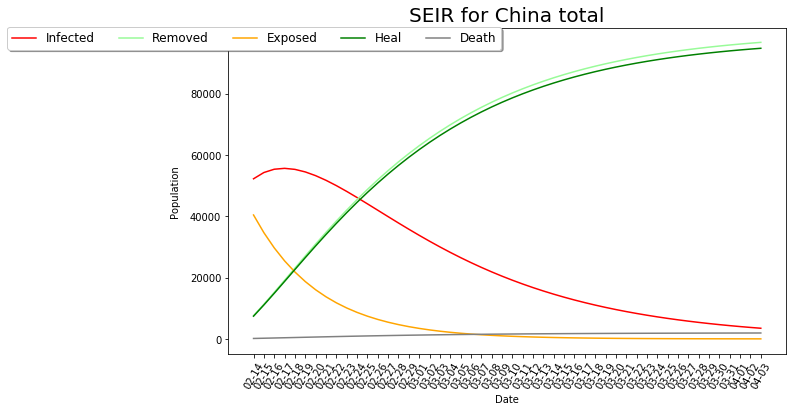

The MAPE is: 
0.7374279615134695


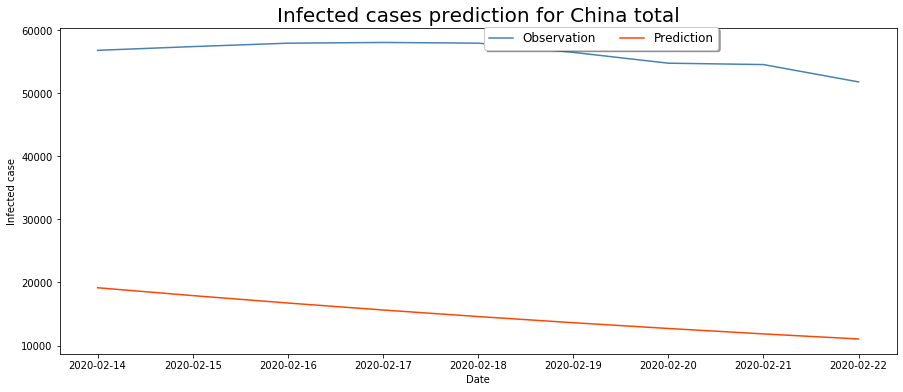

In [8]:
result = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=China_population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for China total', death_rate=0.02, show_Sus = False,\
                  starting_point = China_total['Date'].max()+datetime.timedelta(days=1))
result['Date'] = list((China_total['Date'].min() + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(50))

"""
Calculate MAPE test score using SEIR model result
"""
test = SIR_data[SIR_data['Date'] >= datetime.datetime(2020, 2, 14)]
test = test[test['Country']=='China'].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
plot_test_data_with_MAPE(test, result, 'Infected cases prediction for China total')

### Estimate China, Ex-Hubei

Maximum infected case:  10688


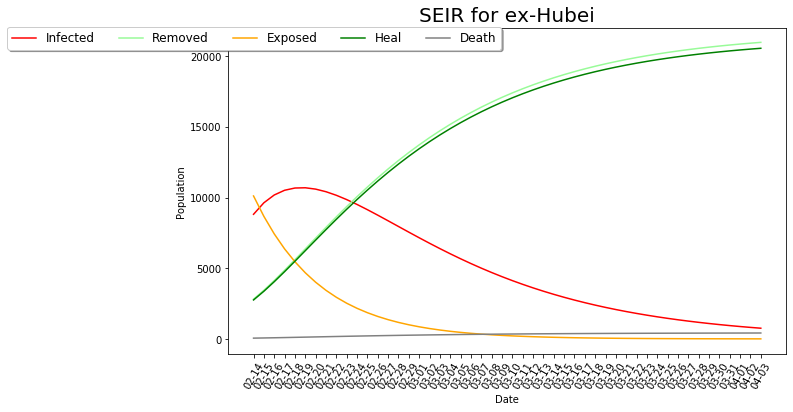

The MAPE is: 
0.5546091447126744


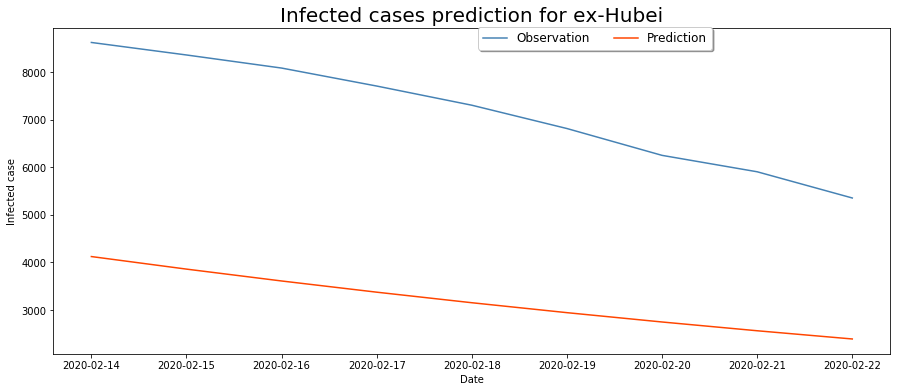

In [9]:
# China, Ex-Hubei data preparation

SIR_data_train = SIR_data[SIR_data['Date'] < datetime.datetime(2020, 2, 14)] 
NotHubei_train = SIR_data_train[(SIR_data_train['Country']=='China')&(df['Province']!='Hubei')].groupby('Date')\
            .agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()

nothubei_dxy = get_China_exclude_province(China_dxy,"Hubei Province")
                                       
population = China_population - Hubei_population
est_beta = 402/population # based on MCMC result

## use the last observation as the initial point in the new SEIR model
I0 = list(NotHubei_train['I'])[-1]
R0 = list(NotHubei_train['R'])[-1]
E0 = nothubei_dxy['E'].iloc[-1] #1/4
S0 = population - I0 - E0 - R0

result2 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for ex-Hubei', death_rate=0.02, show_Sus = False,\
                  starting_point = NotHubei_train['Date'].max()+datetime.timedelta(days=1))

result2['Date'] = list((NotHubei_train['Date'].min() + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(50))

"""
Calculate MAPE test score using SEIR model result
"""
test = SIR_data[SIR_data['Date'] >= datetime.datetime(2020, 2, 14)] 
test = test[(test['Country']=='China')&(test['Province']!='Hubei')].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
plot_test_data_with_MAPE(test, result2, 'Infected cases prediction for ex-Hubei')

## Estimate Hubei 
Which is equal China total - Ex-Hubei


Maximum infected case:  45007


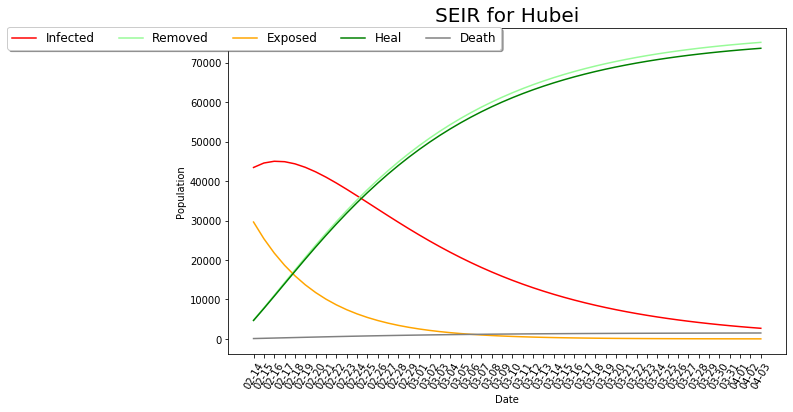

The MAPE is: 
0.7664061184760728


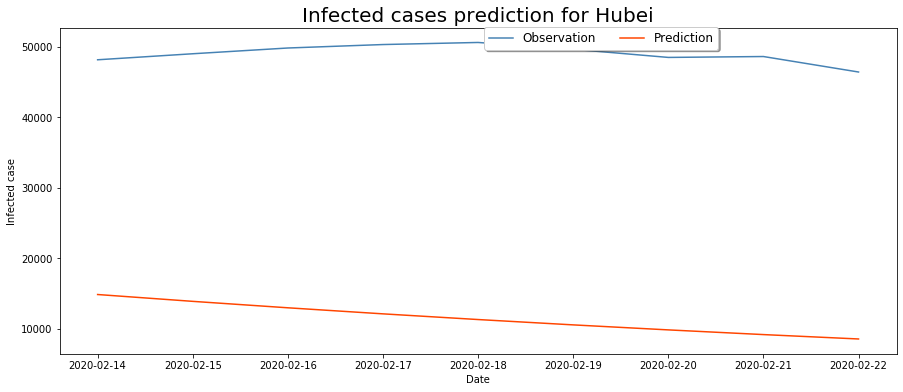

In [10]:
# Hubei data preparation

SIR_data_train = SIR_data[SIR_data['Date'] < datetime.datetime(2020, 2, 14)] 
Hubei_train = SIR_data_train[(SIR_data_train['Country']=='China')&(df['Province']=='Hubei')].groupby('Date')\
            .agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()

hubei_dxy = get_province_df(China_dxy,"Hubei Province") # hubei_dxy suspected/'E' column is all 0
                                       
population = Hubei_population
est_beta = 1457.2/population # based on MCMC result

## use the last observation as the initial point in the new SEIR model
I0 = list(Hubei_train['I'])[-1]
R0 = list(Hubei_train['R'])[-1]
E0 = list(Hubei_train['I'])[-2] # 3/4
S0 = population - I0 - E0 - R0

result2 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for Hubei', death_rate=0.02, show_Sus = False,\
                  starting_point = Hubei_train['Date'].max()+datetime.timedelta(days=1))

result2['Date'] = list((Hubei_train['Date'].min() + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(50))

"""
Calculate MAPE test score using SEIR model result
"""
test = SIR_data[SIR_data['Date'] >= datetime.datetime(2020, 2, 14)] 
test = test[(test['Country']=='China')&(test['Province']=='Hubei')].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
plot_test_data_with_MAPE(test, result2, 'Infected cases prediction for Hubei')

## Estimate Ex-China


Maximum infected case:  520


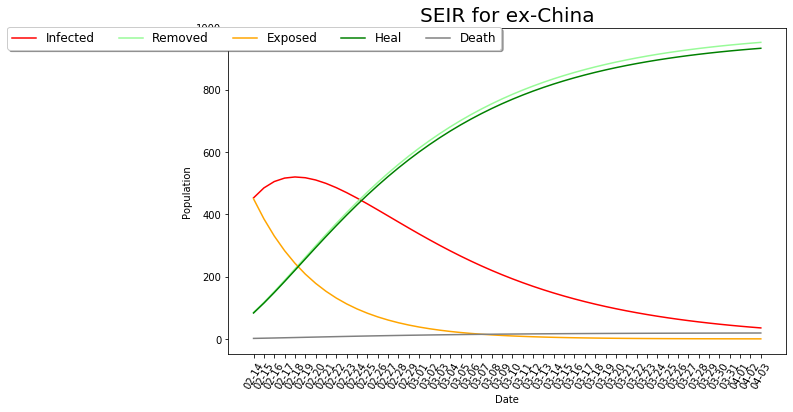

The MAPE is: 
0.7727992302419826


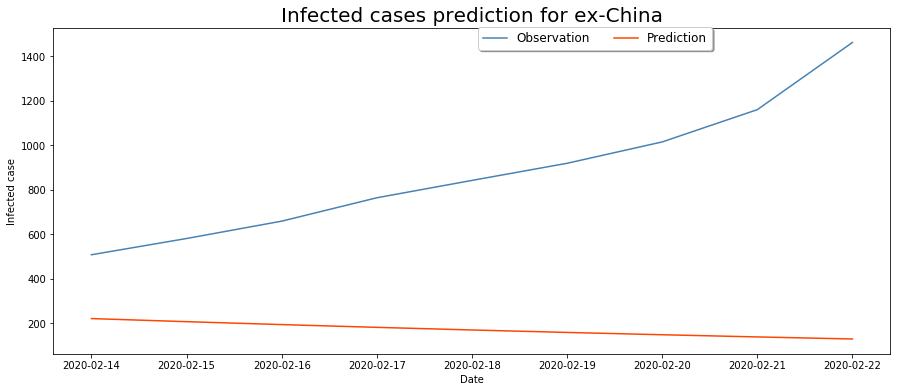

In [11]:
# Ex-China data preparation

SIR_data_train = SIR_data[SIR_data['Date'] < datetime.datetime(2020, 2, 14)] 
NotChina_train = SIR_data_train[SIR_data_train['Country']!='China'].groupby('Date')\
            .agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
"""
parameter for SEIR model
"""
world_population = 7000000000 - China_population # assumption
population = world_population
est_beta = 47/population # based on MCMC result

## use the last observation as the initial point in the new SEIR model
I0 = list(NotChina_train['I'])[-1]
R0 = list(NotChina_train['R'])[-1]
E0 = list(NotChina_train['I'])[-2] # suppose the number of exposed cases outside China
S0 = population - I0 - E0 - R0

result3 = run_SEIR(Est_beta = est_beta, econ=50, E0=E0, R0=R0, I0 = I0, population=population,
             rateIR=1/14, rateAl = 1/7,
             title = 'SEIR for ex-China', death_rate=0.02, show_Sus = False,\
                  starting_point = NotChina_train['Date'].max()+datetime.timedelta(days=1))

result3['Date'] = list((NotChina_train['Date'].min() + datetime.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(50))

"""
Calculate MAPE test score using SEIR model result
"""
test = SIR_data[SIR_data['Date'] >= datetime.datetime(2020, 2, 14)] 
test = test[test['Country']!='China'].groupby('Date').agg({'Confirmed':'sum','R':'sum','I':'sum'}).reset_index()
plot_test_data_with_MAPE(test, result3, 'Infected cases prediction for ex-China')